In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#### Generating CSV

In [2]:
import pandas as pd

# Actual hydrogel degradation timepoints (in hours)
actual_hours = [0, 24, 30, 48, 72, 95, 120, 168, 192, 216, 264]

data = []
global_well_id = 1

for pH in [5, 6, 7, 8]:
    for local_well in range(1, 49):  # 48 wells per pH
        row = {
            'Well': global_well_id,
            'pH': pH
        }
        for i, hour in enumerate(actual_hours):
            day_col = f'Day {i + 1}'  # Still name it Day 1 to Day 11
            filename = f'cropped_{hour}hr_pH{pH}_W{local_well}.JPG'
            row[day_col] = filename
        data.append(row)
        global_well_id += 1

df = pd.DataFrame(data)
df.to_csv("hydrogel_dataset.csv", index=False)
print("✅ CSV file 'hydrogel_dataset.csv' generated with corrected timestamps.")



✅ CSV file 'hydrogel_dataset.csv' generated with corrected timestamps.


#### Separate CSVs

In [3]:
df = pd.read_csv("hydrogel_dataset.csv")


print(df['pH'].value_counts())


test_df = df.groupby('pH', group_keys=False).apply(lambda x: x.sample(n=10, random_state=42))


remaining_df = df.drop(test_df.index)


train_df = remaining_df.groupby('pH', group_keys=False).apply(lambda x: x.sample(n=33, random_state=42))


val_df = remaining_df.drop(train_df.index)


train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("Train size:", train_df.shape)
print("Val size:", val_df.shape)
print("Test size:", test_df.shape)

train_df.to_csv("train.csv", index=False)
val_df.to_csv("val.csv", index=False)
test_df.to_csv("test.csv", index=False)


5    48
6    48
7    48
8    48
Name: pH, dtype: int64
Train size: (132, 13)
Val size: (20, 13)
Test size: (40, 13)


In [4]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
val_df = pd.read_csv('val.csv')

#### RESNET + LSTM MODEL 

In [5]:
import os
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms


In [6]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])


In [7]:
image_sequences = []
labels = []

for i, row in tqdm(train_df.iterrows(), total=len(train_df)):
    pH = int(row['pH'])
    well_sequence = []

    for day in row[2:]:  # skip well_num and pH
        found = False
        for time_folder in os.listdir('Split_Data1/train'):
            time_path = os.path.join('Final_Data', time_folder)
            if not os.path.isdir(time_path): continue
            for pH_folder in os.listdir(time_path):
                pH_path = os.path.join(time_path, pH_folder)
                if not os.path.isdir(pH_path): continue
                img_path = os.path.join(pH_path, day)
                if os.path.exists(img_path):
                    img = cv2.imread(img_path)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = transform(img)
                    well_sequence.append(img)
                    found = True
                    break
            if found:
                break

    if len(well_sequence) == 11:
        image_sequences.append(torch.stack(well_sequence))  # (11, 3, 224, 224)
        labels.append(pH - 5)  # Convert pH 5-8 to class 0-3


100%|█████████████████████████████████████████| 132/132 [00:09<00:00, 14.16it/s]


In [8]:
test_image_sequences = []
test_labels = []

for i, row in tqdm(test_df.iterrows(), total=len(test_df)):
    pH = int(row['pH'])
    well_sequence = []

    for day in row[2:]:  # skip well_num and pH
        found = False
        for time_folder in os.listdir('Split_Data1/test'):
            time_path = os.path.join('Final_Data', time_folder)
            if not os.path.isdir(time_path): continue
            for pH_folder in os.listdir(time_path):
                pH_path = os.path.join(time_path, pH_folder)
                if not os.path.isdir(pH_path): continue
                img_path = os.path.join(pH_path, day)
                if os.path.exists(img_path):
                    img = cv2.imread(img_path)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = transform(img)
                    well_sequence.append(img)
                    found = True
                    break
            if found:
                break

    if len(well_sequence) == 11:
        test_image_sequences.append(torch.stack(well_sequence))  # (11, 3, 224, 224)
        test_labels.append(pH - 5)  # Convert pH 5-8 to class 0-3

100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 14.18it/s]


In [9]:
class HydrogelDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

dataset = HydrogelDataset(image_sequences, labels)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)
test_dataset = HydrogelDataset(test_image_sequences, test_labels)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)  # No need for shuffle during testing


In [10]:
resnet = models.resnet18(pretrained=True)
resnet.fc = nn.Identity()  # remove last FC layer
resnet.eval()

cnn_lstm = nn.Sequential(
    nn.LSTM(input_size=512, hidden_size=256, num_layers=1, batch_first=True),
    nn.Linear(256, 4)  # 4 pH classes
)


/Users/tishabhavsar/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/tishabhavsar/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = resnet.to(device)
cnn_lstm = cnn_lstm.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_lstm.parameters(), lr=1e-4)

for epoch in range(20):
    for seqs, lbls in tqdm(dataloader):
        batch_size = seqs.shape[0]
        seqs = seqs.to(device)  # (B, 11, 3, 224, 224)
        lbls = lbls.to(device)

        features = []
        for t in range(seqs.shape[1]):
            img_batch = seqs[:, t, :, :, :]  # (B, 3, 224, 224)
            with torch.no_grad():
                feat = resnet(img_batch)  # (B, 512)
            features.append(feat)

        features = torch.stack(features, dim=1)  # (B, 11, 512)

        outputs, _ = cnn_lstm[0](features)  # LSTM
        final_out = outputs[:, -1, :]  # last timestep
        preds = cnn_lstm[1](final_out)  # FC Layer

        loss = criterion(preds, lbls)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


100%|███████████████████████████████████████████| 14/14 [00:05<00:00,  2.64it/s]


Epoch 1, Loss: 1.7100


100%|███████████████████████████████████████████| 14/14 [00:05<00:00,  2.65it/s]


Epoch 2, Loss: 1.4257


100%|███████████████████████████████████████████| 14/14 [00:05<00:00,  2.69it/s]


Epoch 3, Loss: 1.2956


100%|███████████████████████████████████████████| 14/14 [00:05<00:00,  2.67it/s]


Epoch 4, Loss: 1.4718


100%|███████████████████████████████████████████| 14/14 [00:05<00:00,  2.63it/s]


Epoch 5, Loss: 0.8031


100%|███████████████████████████████████████████| 14/14 [00:05<00:00,  2.66it/s]


Epoch 6, Loss: 1.2788


100%|███████████████████████████████████████████| 14/14 [00:05<00:00,  2.64it/s]


Epoch 7, Loss: 1.6629


100%|███████████████████████████████████████████| 14/14 [00:05<00:00,  2.67it/s]


Epoch 8, Loss: 0.7303


100%|███████████████████████████████████████████| 14/14 [00:05<00:00,  2.63it/s]


Epoch 9, Loss: 1.3000


100%|███████████████████████████████████████████| 14/14 [00:05<00:00,  2.69it/s]


Epoch 10, Loss: 0.3684


100%|███████████████████████████████████████████| 14/14 [00:05<00:00,  2.67it/s]


Epoch 11, Loss: 0.9979


100%|███████████████████████████████████████████| 14/14 [00:05<00:00,  2.67it/s]


Epoch 12, Loss: 0.4910


100%|███████████████████████████████████████████| 14/14 [00:05<00:00,  2.67it/s]


Epoch 13, Loss: 0.5040


100%|███████████████████████████████████████████| 14/14 [00:05<00:00,  2.69it/s]


Epoch 14, Loss: 0.4476


100%|███████████████████████████████████████████| 14/14 [00:05<00:00,  2.65it/s]


Epoch 15, Loss: 0.0997


100%|███████████████████████████████████████████| 14/14 [00:05<00:00,  2.66it/s]


Epoch 16, Loss: 0.3211


100%|███████████████████████████████████████████| 14/14 [00:05<00:00,  2.68it/s]


Epoch 17, Loss: 0.1263


100%|███████████████████████████████████████████| 14/14 [00:05<00:00,  2.67it/s]


Epoch 18, Loss: 0.3005


100%|███████████████████████████████████████████| 14/14 [00:05<00:00,  2.67it/s]


Epoch 19, Loss: 0.2671


100%|███████████████████████████████████████████| 14/14 [00:05<00:00,  2.64it/s]

Epoch 20, Loss: 0.5535


In [12]:
cnn_lstm.eval()
resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
correct = 0
total = 0

with torch.no_grad():
    for seqs, lbls in test_dataloader:  # replace with test_dataloader if you have one
        seqs = seqs.to(device)
        lbls = lbls.to(device)

        features = []
        for t in range(seqs.shape[1]):
            img_batch = seqs[:, t, :, :, :]
            feat = resnet(img_batch)
            features.append(feat)

        features = torch.stack(features, dim=1)  # (B, 11, 512)

        outputs, _ = cnn_lstm[0](features)
        final_out = outputs[:, -1, :]
        preds = cnn_lstm[1](final_out)

        _, predicted = torch.max(preds.data, 1)
        total += lbls.size(0)
        correct += (predicted == lbls).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 78.95%


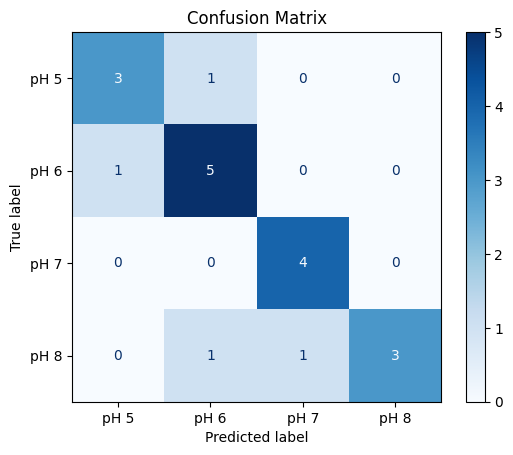

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

all_preds = []
all_lbls = []

with torch.no_grad():
    for seqs, lbls in test_dataloader:
        seqs = seqs.to(device)
        lbls = lbls.to(device)
        features = []
        for t in range(seqs.shape[1]):
            feat = resnet(seqs[:, t, :, :, :])
            features.append(feat)
        features = torch.stack(features, dim=1)
        outputs, _ = cnn_lstm[0](features)
        final_out = outputs[:, -1, :]
        preds = cnn_lstm[1](final_out)
        _, predicted = torch.max(preds.data, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_lbls.extend(lbls.cpu().numpy())

# Plot
cm = confusion_matrix(all_lbls, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["pH 5", "pH 6", "pH 7", "pH 8"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()